In [ ]:
%%bash
cd darknet
sed -i 's/OPENCV=1/OPENCV=0/' Makefile
# In case you dont have a GPU, make sure to comment out the
# below 3 lines
sed -i 's/GPU=0/GPU=1/' Makefile
sed -i 's/CUDNN=1/CUDNN=0/' Makefile
sed -i 's/CUDNN_HALF=1/CUDNN_HALF=0/' Makefile

In [ ]:
%%bash
#compile darkent source code
cd darknet
make

In [ ]:
!wget - quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

In [ ]:
%%bash
#I had to use the flag -dont_show cause wasnt working. Try to run wiithout it
cd darknet
./darknet detector test cfg/coco.data cfg/yolov4.cfg ../yolov4.weights data/person.jpg -dont_show

In [7]:
!wget https://github.com/AlexeyAB/darknet/releases/download/yolov4/yolov4-tiny.conv.29

--2025-12-05 04:18:45--  https://github.com/AlexeyAB/darknet/releases/download/yolov4/yolov4-tiny.conv.29
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/75388965/a876d846-96cd-4e18-9ba7-f384d9e025be?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-04T20%3A38%3A02Z&rscd=attachment%3B+filename%3Dyolov4-tiny.conv.29&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-04T19%3A37%3A27Z&ske=2025-12-04T20%3A38%3A02Z&sks=b&skv=2018-11-09&sig=vPcKAYoOS%2FKrkHNC0gEUBqyF9TpblGZBLd8A%2Fju35%2FU%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NDg4MDQwNSwibmJmIjoxNzY0ODc4NjA1LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJv

In [8]:
%%bash
cd darknet
# copy the base config for tiny
cp cfg/yolov4-tiny-custom.cfg cfg/yolov4-tiny-dartboard.cfg

# set max_batches — for a small custom dataset you might set something like 4000
sed -i 's/max_batches = 500200/max_batches = 4000/' cfg/yolov4-tiny-dartboard.cfg

# adjust subdivisions to fit your GPU / memory
sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov4-tiny-dartboard.cfg

# adjust learning-rate schedule (steps) relative to max_batches
sed -i 's/steps=400000,450000/steps=3200,3600/' cfg/yolov4-tiny-dartboard.cfg

# change number of classes = 1 (since only dartboard)
sed -i 's/classes=80/classes=1/g' cfg/yolov4-tiny-dartboard.cfg

# update the number of filters in the convolution layers preceding each YOLO layer
# filters formula: filters = (classes + 5) * 3 = (1 + 5) * 3 = 18
sed -i 's/filters=255/filters=18/g' cfg/yolov4-tiny-dartboard.cfg
# likewise for any other filter lines (if more than one)
sed -i 's/filters=57/filters=18/g' cfg/yolov4-tiny-dartboard.cfg

In [9]:
%%bash
mkdir backup


In [3]:
!mkdir -p predictions

for f in image_paths:
    !./darknet detector test ... {f} -dont_show
    !mv predictions.jpg predictions/{stem(f)}_pred.jpg


In [33]:
import os
import cv2
import subprocess
import re
from glob import glob
from utils import GroundTruthLoader, Evaluator, ResultWriter
import matplotlib.pyplot as plt
# ==========================================================
#                       YOLO Detector
# ==========================================================


In [59]:
class YOLODetector:
    def __init__(self,
                 data_path="darknet/data/obj.data",
                 cfg_path="darknet/cfg/yolov4-tiny-dartboard.cfg",
                 weights_path="backup/yolov4-tiny-dartboard_best.weights",
                 darknet_binary="./darknet/darknet"):
        
        self.data_path = data_path
        self.cfg_path = cfg_path
        self.weights_path = weights_path
        self.darknet = darknet_binary

    def detect(self, image_path):
        """
        Runs Darknet and returns bounding boxes as (x, y, w, h)
        """
        cmd = [
            self.darknet,
            "detector", "test",
            self.data_path,
            self.cfg_path,
            self.weights_path,
            image_path,
            "-dont_show",
            "-ext_output",
            "> output.txt"
        ]


        result = subprocess.run(cmd, capture_output=True, text=True)
        output = result.stdout

        detections = []

        # Pattern for lines like: dartboard: 98%
        class_conf_pattern = r"(\w+):\s*(\d+)%"
        # Pattern for bounding box coordinates
        box_pattern = r"left_x:\s*(-?\d+)\s*top_y:\s*(-?\d+)\s*width:\s*(\d+)\s*height:\s*(\d+)"

        class_conf_matches = re.findall(class_conf_pattern, output)
        box_matches = re.findall(box_pattern, output)

        boxes = []
        # Pair them together
        for (cls, conf), (x, y, w, h) in zip(class_conf_matches, box_matches):
            if float(conf) < 25.0:
                continue
            boxes.append((int(x), int(y), int(w), int(h)))

        return boxes
    


In [ ]:
detector = YOLODetector()

In [37]:
image_path = "Dartboard/dart14.jpg"

In [38]:
frame = cv2.imread(image_path)

In [39]:
detected_boxes = detector.detect(image_path)

In [40]:
detected_boxes

[(35, 1, 330, 336), (483, 537, 292, 126), (912, 8, 272, 269)]

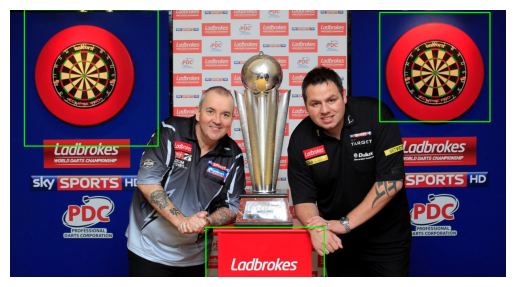

In [43]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
gt_boxes = sgt_loader.get(image_root)

In [46]:
# Draw detections (GREEN)
for (x, y, w, h) in detected_boxes:
    print(f"Drawing box at: x={x}, y={y}, w={w}, h={h}")
    cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 2)

Drawing box at: x=35, y=1, w=330, h=336
Drawing box at: x=483, y=537, w=292, h=126
Drawing box at: x=912, y=8, w=272, h=269


In [47]:
gt_loader =  GroundTruthLoader()

In [52]:
image_path

'Dartboard/dart14.jpg'

In [54]:
image_root = os.path.splitext(os.path.basename(image_path))[0]

In [55]:
image_root

'dart14'

In [56]:
gt_boxes = gt_loader.get(image_root)

In [57]:
gt_boxes

[(983.0, 96.0, 127.0, 135.0)]

In [58]:
detected_boxes

[(35, 1, 330, 336), (483, 537, 292, 126), (912, 8, 272, 269)]

In [45]:
# Draw detection (green)
for det in detected_boxes:
    x, y, w, h = det
    cv2.rectangle(frame, (x,y), (x+w,y+h), (0,255,0), 2)    